In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Data 준비하기

In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data
tfr_train = '/content/drive/MyDrive/Colab/oxford_pet_tfr/loc_train.tfr'
tfr_valid = '/content/drive/MyDrive/Colab/oxford_pet_tfr/loc_val.tfr'

# class list
cls_file = '/content/drive/MyDrive/Colab/class_list.txt'
class_list = []
with open(cls_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n','')
        class_list.append(line)

In [4]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [5]:
IMG_SIZE = 224
N_CLASS = len(class_list)

N_EPOCHS = 50
N_BATCH = 40

learning_rate = 0.0001

N_TRAIN = 3000
N_VAL = 685
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [6]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [7]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [8]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_valid)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

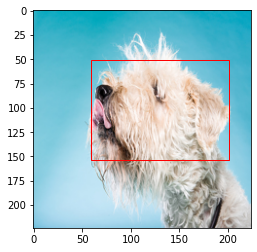

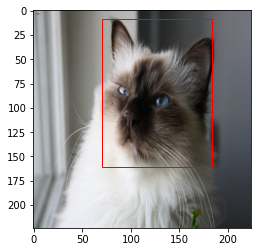

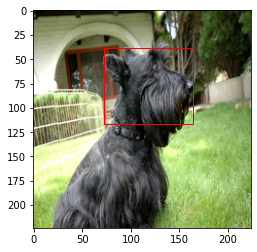

In [9]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(3):
    
    '''bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

### Pretrained MobileNetV2로 Localization 학습하기

In [10]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [11]:
## MobileNet V2의 pretrained model을 load
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
## localization을 위한 network
## 마지막 layer는 4개의 node로 x,y,w,h를 예측하도록 함
model = keras.models.Sequential()
model.add(mobilenetv2)
model.add(GlobalAveragePooling2D())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(4, activation='sigmoid')) # x,y,w,h
# model.summary()

In [13]:
def loss_fn(y_true, y_pred):
    return keras.losses.MeanSquaredError()(y_true, y_pred)

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn)

In [14]:
model.fit(train_dataset, 
          epochs=N_EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_dataset,
          validation_steps=validation_steps)

Epoch 1/50
75/75 [==============================] - 64s 272ms/step - loss: 0.0184 - val_loss: 0.0233
Epoch 2/50
75/75 [==============================] - 21s 265ms/step - loss: 0.0054 - val_loss: 0.0199
Epoch 3/50
75/75 [==============================] - 22s 269ms/step - loss: 0.0032 - val_loss: 0.0122
Epoch 4/50
75/75 [==============================] - 22s 273ms/step - loss: 0.0026 - val_loss: 0.0112
Epoch 5/50
75/75 [==============================] - 22s 272ms/step - loss: 0.0020 - val_loss: 0.0098
Epoch 6/50
75/75 [==============================] - 22s 270ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 7/50
75/75 [==============================] - 22s 277ms/step - loss: 0.0017 - val_loss: 0.0068
Epoch 8/50
75/75 [==============================] - 22s 271ms/step - loss: 0.0017 - val_loss: 0.0072
Epoch 9/50
75/75 [==============================] - 22s 272ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 10/50
75/75 [==============================] - 22s 271ms/step - loss: 0.0014 - val_lo

In [15]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), 
                          pred_rect_w, pred_rect_h,
                          fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()    

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# calculate IOU (Intersection Over Union)
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH #5
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    ## 정답 box 그리기
    flag = (i == validation_steps-1)
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_BATCH):
        if(flag):
            if idx == res:
                flag = False
                break
            
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
            
        w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
        h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

        w_sub1 = np.abs(xmax - pred_xmax)
        h_sub1 = np.abs(ymax - pred_ymax)
        w_sub2 = np.abs(xmin - pred_xmin)
        h_sub2 = np.abs(ymin - pred_ymin)

        iou = (w_inter * h_inter) / ((w_union * h_union) - (w_sub1 * h_sub1) - (w_sub2 * h_sub2))
        avg_iou += iou / N_VAL

print(avg_iou)

0.6700293128419103


## Classification을 추가하여 Multi-task Learning으로 Localization 학습하기

### 고양이/개 2개 class로 classification

In [17]:
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.float32)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.float32)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([bi_cls_label, x, y, w, h], -1) # bi_cls_label 추가
    
    return image, gt

In [18]:
train_dataset = tf.data.TFRecordDataset(tfr_train)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [19]:
val_dataset = tf.data.TFRecordDataset(tfr_valid)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [20]:
def create_2c_model():
    mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    gap = GlobalAveragePooling2D()(mobilenetv2.output)

    dense_b1_1 = Dense(256)(gap)
    bn_b1_2 = BatchNormalization()(dense_b1_1)
    relu_b1_3 = ReLU()(bn_b1_2)
    dense_b1_4 = Dense(64)(relu_b1_3)
    bn_b1_5 = BatchNormalization()(dense_b1_4)
    relu_b1_6 = ReLU()(bn_b1_5)
    output1 = Dense(2, activation='softmax')(relu_b1_6)  # classification

    dense_b2_1 = Dense(256)(gap)
    bn_b2_2 = BatchNormalization()(dense_b2_1)
    relu_b2_3 = ReLU()(bn_b2_2)
    dense_b2_4 = Dense(64)(relu_b2_3)
    bn_b2_5 = BatchNormalization()(dense_b2_4)
    relu_b2_6 = ReLU()(bn_b2_5)
    output2 = Dense(4, activation='sigmoid')(relu_b2_6)  # localization

    concat = Concatenate()([output1, output2])

    return keras.Model(inputs=mobilenetv2.input, outputs=concat)


model = create_2c_model()

In [21]:
def loss_fn(y_true, y_pred):
    cls_labels = tf.cast(y_true[:,:1], tf.int64)
    loc_labels = y_true[:,1:]  
    
    cls_preds = y_pred[:,:2]
    loc_preds = y_pred[:,2:]  
    
    cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds)
    loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)
    
    return cls_loss + 5*loc_loss

In [22]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn)

In [23]:
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/50
75/75 [==============================] - 27s 284ms/step - loss: 0.2810 - val_loss: 5.9554
Epoch 2/50
75/75 [==============================] - 22s 272ms/step - loss: 0.1171 - val_loss: 10.6616
Epoch 3/50
75/75 [==============================] - 22s 272ms/step - loss: 0.0836 - val_loss: 9.0094
Epoch 4/50
75/75 [==============================] - 22s 268ms/step - loss: 0.0698 - val_loss: 8.4526
Epoch 5/50
75/75 [==============================] - 21s 265ms/step - loss: 0.0548 - val_loss: 10.0502
Epoch 6/50
75/75 [==============================] - 22s 272ms/step - loss: 0.0583 - val_loss: 8.4971
Epoch 7/50
75/75 [==============================] - 22s 271ms/step - loss: 0.0457 - val_loss: 11.2334
Epoch 8/50
75/75 [==============================] - 22s 271ms/step - loss: 0.0534 - val_loss: 11.3772
Epoch 9/50
75/75 [==============================] - 22s 273ms/step - loss: 0.0432 - val_loss: 11.2103
Epoch 10/50
75/75 [==============================] - 22s 272ms/step - loss: 0.0452 - v

In [24]:
idx = 2
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH #5
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):    
    flag = (i == validation_steps-1)
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    prediction = model.predict(val_data)
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    for idx in range(N_BATCH):
        if (flag):
            if idx == res:
                flag = False
                break
                
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        
        w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
        h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

        w_sub1 = np.abs(xmax - pred_xmax)
        h_sub1 = np.abs(ymax - pred_ymax)
        w_sub2 = np.abs(xmin - pred_xmin)
        h_sub2 = np.abs(ymin - pred_ymin)

        iou = (w_inter * h_inter) / ((w_union * h_union) - (w_sub1 * h_sub1) - (w_sub2 * h_sub2))
        avg_iou += iou / N_VAL

print(avg_iou)

0.7227282874994897


## 새로운 Image로 Test하기

In [27]:
from PIL import Image

In [28]:
## Image upload 후 실행
test_image = '/content/drive/MyDrive/Colab/test_cat.jpg'

image = Image.open(test_image)
image = image.resize((224, 224))
image = np.array(image)
image = image/255.

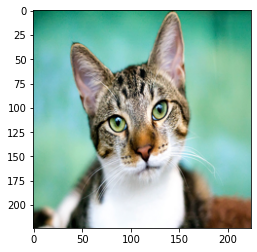

In [29]:
plt.imshow(image)
plt.show()

In [30]:
image.shape

(224, 224, 3)

In [31]:
image = np.reshape(image, (1, 224, 224, 3))

In [32]:
pred = model.predict(image)
print(pred)

[[2.7545232e-08 1.0000000e+00 4.5791575e-01 4.3477166e-01 4.8593187e-01
  8.1056058e-01]]


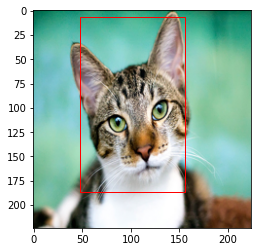

In [33]:
## 예측한 BBox 확인
prediction = model.predict(image)
pred_x = prediction[0,2]
pred_y = prediction[0,3]
pred_w = prediction[0,4]
pred_h = prediction[0,5]
pred_xmin = pred_x - pred_w/2.
pred_ymin = pred_y - pred_h/2.
pred_rect_x = int(pred_xmin * IMG_SIZE)
pred_rect_y = int(pred_ymin * IMG_SIZE)
pred_rect_w = int(pred_w * IMG_SIZE)
pred_rect_h = int(pred_h * IMG_SIZE)

pred_rect = Rectangle((pred_rect_x, pred_rect_y), 
                      pred_rect_w, pred_rect_h,
                      fill=False, color='red')
plt.axes().add_patch(pred_rect)

plt.imshow(image[0])
plt.show()